# Radiant Environment Maps

Radiant Environment Maps (REMs, also called "light-probes" or "skydomes" in different contexts) define the amount of light (radiance) travelling in all directions at a point in the Earth atmosphere. REMs can be computed using libRadtran with the radiance options ('umu' and 'phi') that allow specification of the directions in which one would like to compute the radiance. Most of the solvers in libRadtran can compute radiances, including all the variants of DISORT. One the basic capabilities in MORTICIA is to compute REMs and then to compute ("render") the appearance of targets in a specific radiant environment. This notebook illustrates the computation of REMs using libRadtran.

libRadtran has a number of k-distribution (also called "correlated-k") atmospheric absorption parametrizations. These models allow for more rapid computation of radiances and irradiances, but with limited spectral resolution. One such model for the shortwave spectrum is that by Kato et. al. For the thermal spectrum, there is the Fu parametrization. Read the libRadtran manual for more details. Here, we will use the Kato model to compute the sky/ground appearance as provided by a REM.

The MORTICIA class used for REM computation is morticia.rad.librad.RadEnv.

In [1]:
import morticia.rad.librad as librad
# Use auto reload of librad for development purposes
%load_ext autoreload
%autoreload 1
%aimport morticia.rad.librad
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from ipyparallel import Client  # This is the client class for contacting the hub/controller

%matplotlib inline

In [2]:
        >>> libRadCase = librad.Case(filename='./examples/UVSPEC_AEROSOL.INP')  # Read uvspec input and expand includes
        >>> print libRadCase   # This prints the uvspec input file

atmosphere_file ../data/atmmod/afglus.dat
source solar ../data/solar_flux/atlas_plus_modtran
mol_modify O3 300. DU
day_of_year 170
albedo 0.2
sza 32.0
rte_solver disort
number_of_streams 6
wavelength 299.0 341.0
slit_function_file ../examples/TRI_SLIT.DAT
spline 300 340 1
quiet 
aerosol_vulcan 1
aerosol_haze 6
aerosol_season 1
aerosol_visibility 20.0
aerosol_angstrom 1.1 0.2
aerosol_modify ssa scale 0.85
aerosol_modify gg set 0.70
aerosol_file tau ../examples/AERO_TAU.DAT


In [ ]:
# Load a libRadtran example case
# Be default, any include files are expanded, creating a single set of option keywords
libRadCaseA=librad.Case(filename='./examples/UVSPEC_AEROSOL_1WVL.INP')
libRadCaseA.alter_option(['albedo', '0.5'])
libRadCaseA.alter_option(['phi0', '0.0'])
libRadCaseB=librad.Case(filename='./examples/UVSPEC_AEROSOL_1WVL.INP')
libRadCaseB.alter_option(['albedo', '0.5'])
libRadCaseB.alter_option(['phi0', '0.0'])

In [ ]:
# Build a radiant environment map case
libRadEnvh = librad.RadEnv(base_case=libRadCaseA, n_pol=256, n_azi=128, hemi=True)
libRadEnvf = librad.RadEnv(base_case=libRadCaseB, n_pol=256, n_azi=256, hemi=False)

In [ ]:
paraclient = Client(profile='icebow', sshserver='dgriffith@146.64.246.95', password='dgIceBow')

In [ ]:
paraclient[:].use_dill()

In [ ]:
# Obtain a "load-balanced" view of the engine cluster
paraview = paraclient.load_balanced_view()
# Set the view to blocking mode, which means that we wait for all engines to complete the task before
# control is returned to the client
paraview.block = True

In [ ]:
%time libRadEnvh.run_ipyparallel(ipyparallel_view=paraview)
%time libRadEnvf.run_ipyparallel(ipyparallel_view=paraview)

In [ ]:
import dill

In [ ]:
dill.dump(libRadEnvh, open( "libRadEnvh.dill", "wb" ) )
dill.dump(libRadEnvf, open( "libRadEnvf.dill", "wb" ) )

In [ ]:
with open("libRadEnv.dill", 'rb') as in_strm:
     libRadEnv = dill.load(in_strm)

In [ ]:
print libRadEnvf.hemi, libRadEnvh.hemi

In [ ]:
%time shh = libRadEnvh.sph_harm_fit(degree=4, method='sum')
%time shf = libRadEnvf.sph_harm_fit(degree=4, method='sum')

In [ ]:
#from scipy.special import factorial
#Knm = np.sqrt((2*n+1.0)/(np.pi*4)*factorial(n-m)/factorial(n+m))
n, m = 2, 0
print shf[n][m].values.squeeze()
print shh[n][m].values.squeeze()
print (shf[n][m].values.squeeze()/shh[n][m].values.squeeze()).mean()
#print 1.0/Knm

In [ ]:
sh[2][2].data.squeeze()

In [ ]:
from itertools import chain

In [ ]:
cc = list(chain(*libRadEnv.cases))

In [ ]:
cc[3].alter_option(['sza','0.555'])

In [ ]:
cc[3]

In [ ]:
libRadEnv.cases[1][1]

In [ ]:
np.append([1,2], [3,4])

In [ ]:
xd_uu = xray.concat([xray.concat([case_uu.xd_uu for case_uu in libRadEnv.cases[jj]], dim='phi') 
                     for jj in range(len(libRadEnv.cases))], dim='umu')

In [ ]:
len(libRadEnv.cases)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(libRadEnvf.xd_uu[:,:,1,0,0])

In [ ]:
libRadEnvh.xd_uu.max()

In [ ]:
libRadEnv.cases[0][0].name

In [ ]:
libRadCase.name

In [ ]:
plt.plot((libRadEnvf.paz.data))

In [ ]:
(libRadEnvh.xd_uu/libRadEnvh.xd_uu).data.squeeze()

In [ ]:
from scipy.special import sph_harm

In [ ]:
sph_harm(2,2,np.pi/2,np.pi/4)

In [ ]:
import xray
self = libRadEnvf
azi_angles = self.paz.data  # Propagation zenith angles in radians
pol_angles = self.pza.data   # Propagation polar (zenith) angles in radians
azi_ang_delta = azi_angles[1] - azi_angles[0]
pol_ang_delta = np.abs(pol_angles[1] - pol_angles[0])
# print azi_ang_delta, pol_ang_delta
# Angles to be meshgridded - is this really necessary
# TODO : Check if meshgridding is really necessary
azi_angles, pol_angles = np.meshgrid(azi_angles, pol_angles)
sin_pol_angles = xray.DataArray(np.sin(pol_angles), [self.pza, self.paz])

In [ ]:
plt.imshow(sin_pol_angles)

In [ ]:
from scipy.special import lpmv

In [ ]:
lpmv(0,0,np.array([1,2,3]))

In [ ]:
import numpy as np
import scipy.special
import matplotlib.pyplot as plt

# create a figure window
fig = plt.figure(1, figsize=(9,8))


# Legendre polynomials
x = np.linspace(-1, 1, 256)
lp0 = np.polyval(scipy.special.legendre(0),x)
lp1 = np.polyval(scipy.special.legendre(1),x)
lp2 = np.polyval(scipy.special.legendre(2),x)
lp3 = np.polyval(scipy.special.legendre(3),x)
ax5 = fig.add_subplot(325)
ax5.plot(x,lp0, x,lp1, x,lp2, x,lp3)
ax5.axhline(color="grey", ls="--", zorder=-1)
ax5.axvline(color="grey", ls="--", zorder=-1)
ax5.set_ylim(-1,1.1)
ax5.text(0.5, 0.9,'Legendre', ha='center', va='top',
     transform = ax5.transAxes)


In [ ]:
x = libRadEnvf.xd_uu[:,:128,0,0,0] - libRadEnvh.xd_uu[:,:,0,0,0]

In [ ]:
x.dims

In [ ]:
libRadEnvh.xd_uu['pza'] - libRadEnvf.xd_uu['pza']

In [ ]:
libRadEnvh.xd_uu.values.shape

In [ ]:
libRadEnvf.paz

In [ ]:
(libRadEnvf.xd_uu['paz'].values - libRadEnvf.paz.values).max()

In [ ]:
libRadEnvf.xd_uu.isel(paz=slice(-1,-1))

In [43]:
c = librad.Case(filename='./examples/UVSPEC_CLOUDCOVER_REDISTRIBUTION.INP')
cenv = librad.RadEnv(base_case=c, n_pol=256, n_azi=128, hemi=True, n_sza=48)

In [44]:
c

atmosphere_file ../examples/ATMOSPHERE_IPA.DAT
mol_modify O3 300. DU
albedo 0.2
sza 30.0
rte_solver twostr
pseudospherical 
mol_abs_param Kato
wavelength_index 1 32
wc_file 1D ../examples/WC50_A_R.DAT
cloudcover wc 0.4
interpret_as_level wc
quiet 

In [45]:
cenv.trans_base_case

atmosphere_file ../examples/ATMOSPHERE_IPA.DAT
mol_modify O3 300. DU
albedo 0.2
sza 30.0
rte_solver twostr
pseudospherical 
mol_abs_param Kato
wavelength_index 1 32
interpret_as_level wc
quiet 
output_quantity reflectivity

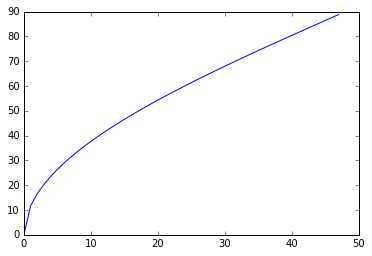

In [20]:
plt.plot(cenv.trans_vza_up.data)

In [46]:
cenv.trans_vza_up

<xray.DataArray 'vza' (vza: 48)>
array([  0.        ,  11.71585239,  16.59784214,  20.36413481,
        23.55646431,  26.38432975,  28.95502437,  31.33220671,
        33.55730976,  35.6590877 ,  37.65846201,  39.57121946,
        41.40962211,  43.1834218 ,  44.90052796,  46.56746344,
        48.1896851 ,  49.77181527,  51.31781255,  52.83110034,
        54.31466529,  55.77113367,  57.2028317 ,  58.61183354,
        60.        ,  61.36901016,  62.72038726,  64.05552023,
        65.37568165,  66.68204293,  67.97568716,  69.25762005,
        70.52877937,  71.79004314,  73.0422367 ,  74.28613895,
        75.52248781,  76.75198509,  77.97530082,  79.19307713,
        80.40593177,  81.61446135,  82.81924422,  84.0208432 ,
        85.21980815,  86.4166783 ,  87.61198454,  88.80625156])
Coordinates:
  * vza      (vza) float64 0.0 11.72 16.6 20.36 23.56 26.38 28.96 31.33 ...
Attributes:
    units: deg
    long_name: View Zenith Angle

In [47]:
cenv.trans_cases[1].outfile

'D:\\Projects\\GitHub\\nbMORTICIA\\rad\\examples\\UVSPEC_CLOUDCOVER_REDISTRIBUTION_x_0001.OUT'